**Instituto Tecnológico de Costa Rica**

**Escuela de Ingeniería en Computación**

**Maestría Académica en Ciencias de la Computación**

**Curso: Electiva Deep Learning**

**Segundo Semestre 2024**

**Profesor: Dr. Luis-Alexander Calvo-Valverde**

---

**Trabajo Práctico:** 3

**Datos de la entrega:** Jueves 7 de noviembre 2024, a más tardar a las 6:00 pm

**Medio de entrega**: Por medio del TEC-Digital.

**Entregables**: Un archivo comprimido con todos los archivos de su solución a este Trabajo Práctico. En caso de requerir mucho espacio, solicitarle al profesor una carpeta en One-Drive para subir la solución.

---

**Estudiantes:**
- Andrey Arguedas Espinoza - 2020426569

# Entregable 1.  Experimentación con Series Temporales

1. El objetivo central es investigar y experimentar en el uso de Deep Learning para la tarea de predicción en secuencias. En particular en series temporales.
1. Se adjunta el dataset, pero puede descargarlo y obtener información de él en: (https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set/data)  u otro de su elección. Sobre todo considerando la capacidad de procesamiento de que disponga.
1. Usted debe proponer e implementar el Diseño Experimental, el cual debe considerar al menos tres arquitecturas: dos existentes y una tercer arquitectura propuesta por Usted, no es problema que sea alguna de las dos primeras con algún cambio propuesto por Usted. Es requisito que se programen las capas requeridas para la red neuronal artificial, no usar frameworks que con la llamada a una función retornen el resultado.
1. Es válido utilizar código de alguna fuente como base, pero debe ser citada claramente la fuente.


## • Prerequisites

### - This version is implemented in Anaconda Navigator, if you want to to run it on Google Colab make sure to have the Pro version and mount the instance
### - Add the dataset to the same path you have the notebook so it loads inmediately

## • Import required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import statsmodels
import time
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM, Bidirectional, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### • Define global variables for the project

In [2]:
#Checkpoints folder for the basic TCNN model
checkpoints_TCN = 'checkpoints_TCN'

#Checkpoints folder for the SegRNN model
checkpoints_SegRNN_LSTM = 'checkpoints_SegRNN_LSTM'

#Checkpoints folder for the SegRNN model
checkpoints_SegRNN_GRU = 'checkpoints_SegRNN_GRU'

#Checkpoints folder for the SCINET model
checkpoints_SCINet = 'checkpoints_SCINet'

checkpoints_transfomer = 'checkpoints_Transformer'

#checkpoint filename to save
checkpoint_filename = 'tsf_model{epoch:02d}.h5'
#checkpoint filename to load
checkpoint_filename_load = 'tsf_model20.h5'

#Size of the past time steps for our sequence
past_time_steps = 4

# The second value is the amount of valid columns for training
reshapable_dimension = (past_time_steps, 6)

#With 10 epochs all the architectures
train_epochs_amount = 20

## • Load the Dataset

In [3]:
# Load dataset from a .txt file
dataset = pd.read_csv('household_power_consumption.txt', delimiter=';', low_memory=False, na_values=['nan','?'])

print(dataset.head())  # Show the first few rows of the dataset
print(dataset.info())

         Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00                4.216                  0.418   234.84   
1  16/12/2006  17:25:00                5.360                  0.436   233.63   
2  16/12/2006  17:26:00                5.374                  0.498   233.29   
3  16/12/2006  17:27:00                5.388                  0.502   233.74   
4  16/12/2006  17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total

### • Do a data transformation for the date and time fields since they can be handled as one, will be easier in the future to handle it this way

In [4]:
# Combine 'Date' and 'Time' columns into a single datetime column
dataset['dt'] = pd.to_datetime(dataset['Date'] + ' ' + dataset['Time'], dayfirst=True, errors='coerce')

# Set the combined 'dt' column as the index
dataset.set_index('dt', inplace=True)

# Drop the original 'Date' and 'Time' columns if no longer needed
dataset.drop(columns=['Date', 'Time'], inplace=True)

# Preview the first few rows
print(dataset.head())
print(dataset.info())

                     Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00          

### • Dataset cleaning: This dataset contains certain registers with invalid or missing values (nearly 1,25% of the rows), we will have to adress this by replace them with mean values of the columns

### After that we will have a dataset that will not give us problems of missing data that can affect the time series.

In [5]:
print("*** Missing values on the dataset *** ")
print(dataset.isnull().sum())

#Adressing the issue
for j in range(0, dataset.shape[1]):
    dataset.iloc[:,j] = dataset.iloc[:,j].fillna(dataset.iloc[:,j].mean())


print("*** After cleaning the dataset ***")
print(dataset.isnull().sum())

*** Missing values on the dataset *** 
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
*** After cleaning the dataset ***
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


### • With a more robust dataset, we can describe completely every column, important to notice we do not have NaN values anymore

In [6]:
# verifying a complete description of the dataframe for all columns
dataset.describe(include='all')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


### • Now we can start to plot the factors that are of our interest.

### First we plot the Global Active Power across time

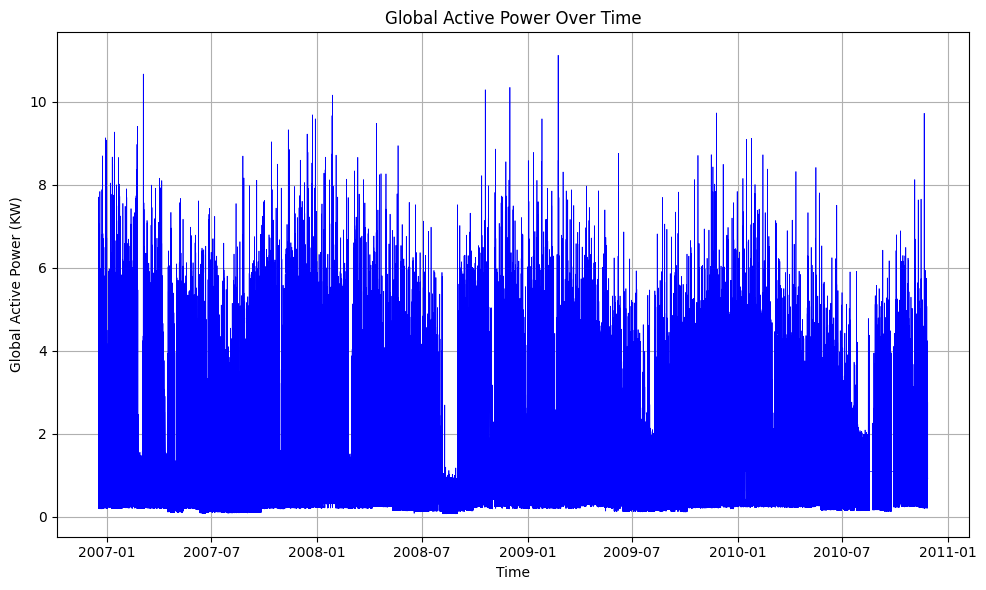

In [7]:
# ploting a graph of global active power consuption trought time
plt.figure(figsize=(10, 6))
plt.plot(dataset['Global_active_power'], label='Global Active Power (kW)', color='blue', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Global Active Power (KW)')
plt.title('Global Active Power Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

### • Now we plot the Global Reactive Power across time

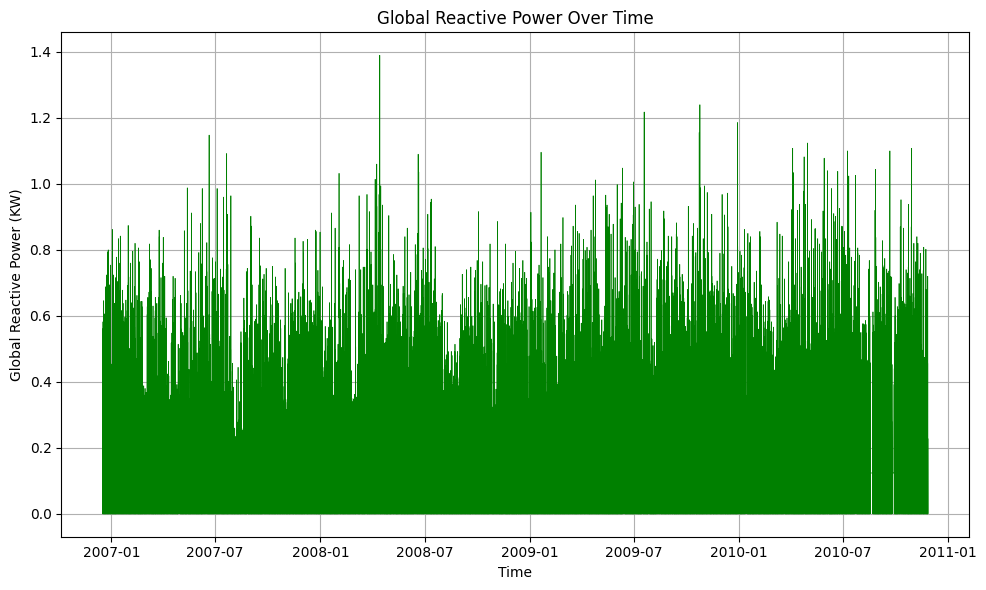

In [8]:
# ploting a graph of global active power consuption trought time
plt.figure(figsize=(10, 6))
plt.plot(dataset['Global_reactive_power'], label='Global Reactive Power (kW)', color='green', linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('Global Reactive Power (KW)')
plt.title('Global Reactive Power Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

### • After seeing this information we see a lot of data across time, but we will be better to plot it per year and compare the 2 variables

<Axes: xlabel='dt'>

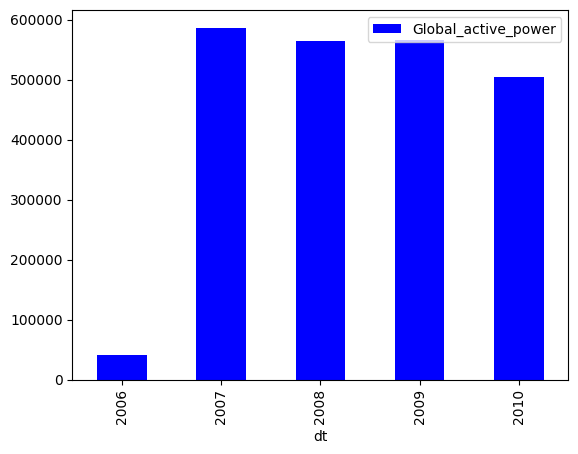

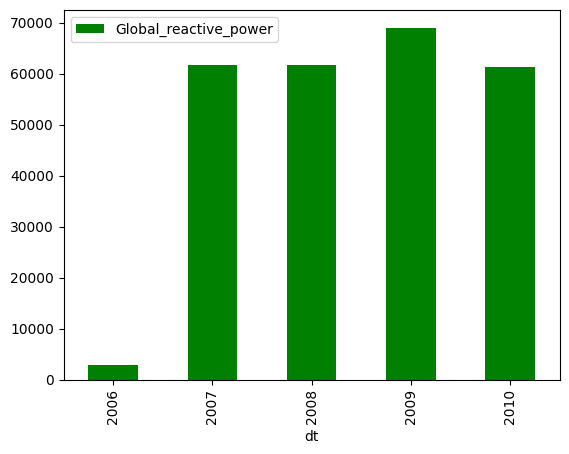

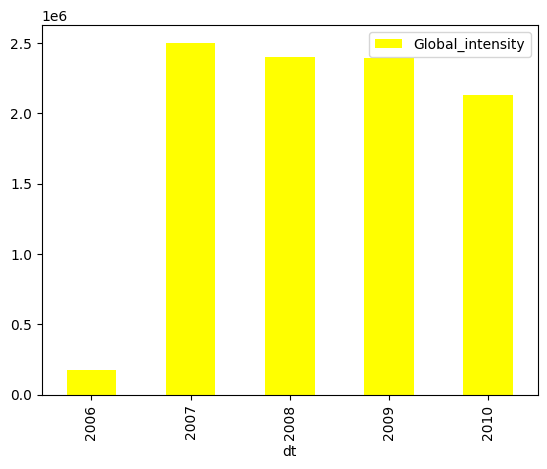

In [9]:
# Dataframe of active power
household_consumption_active_power = dataset.groupby([dataset.index.year])['Global_active_power'].sum().to_frame()
# Dataframe of reactive power
household_consumption_reactive_power = dataset.groupby([dataset.index.year])['Global_reactive_power'].sum().to_frame()
# Dataframe of intensity
household_consumption_intensity = dataset.groupby([dataset.index.year])['Global_intensity'].sum().to_frame()

household_consumption_active_power.plot(kind='bar', color='blue')
household_consumption_reactive_power.plot(kind='bar', color='green')
household_consumption_intensity.plot(kind='bar', color='yellow')

### • Now lets make a complete chart analysis

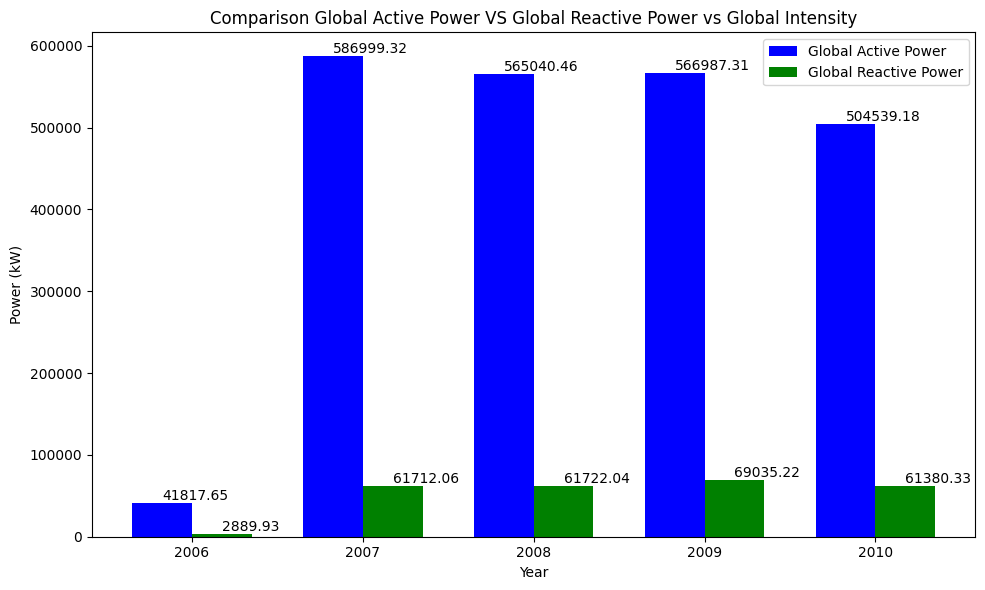

In [10]:
# defing the indix that will be the same for both dataframes
indices = np.arange(len(household_consumption_active_power))

# definig the size of the plot
plt.figure(figsize=(10, 6))

# bar plot of the dataframe of Global_active_power
bars1 = plt.bar(indices, household_consumption_active_power['Global_active_power'], width=0.35, label='Global Active Power', color='blue')

# bar plot of the dataframe of Global_reactive_power
bars2 = plt.bar(indices + 0.35, household_consumption_reactive_power['Global_reactive_power'], width=0.35, label='Global Reactive Power', color='green')

# title and labels names
plt.xlabel('Year')
plt.ylabel('Power (kW)')
plt.title('Comparison Global Active Power VS Global Reactive Power vs Global Intensity')

# defining the ticks of X label using the years that are the the index
plt.xticks(indices + 0.35 / 2, household_consumption_active_power.index)

# adding the legend
plt.legend()

# Adding the values on the top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')

# ploting the graph
plt.tight_layout()
plt.show()

### After seeing this should we delete the 2006 consumption because it is an oultier???

https://articles.outlier.org/calculate-outlier-formula

### Lets check correlation matrix

<Axes: >

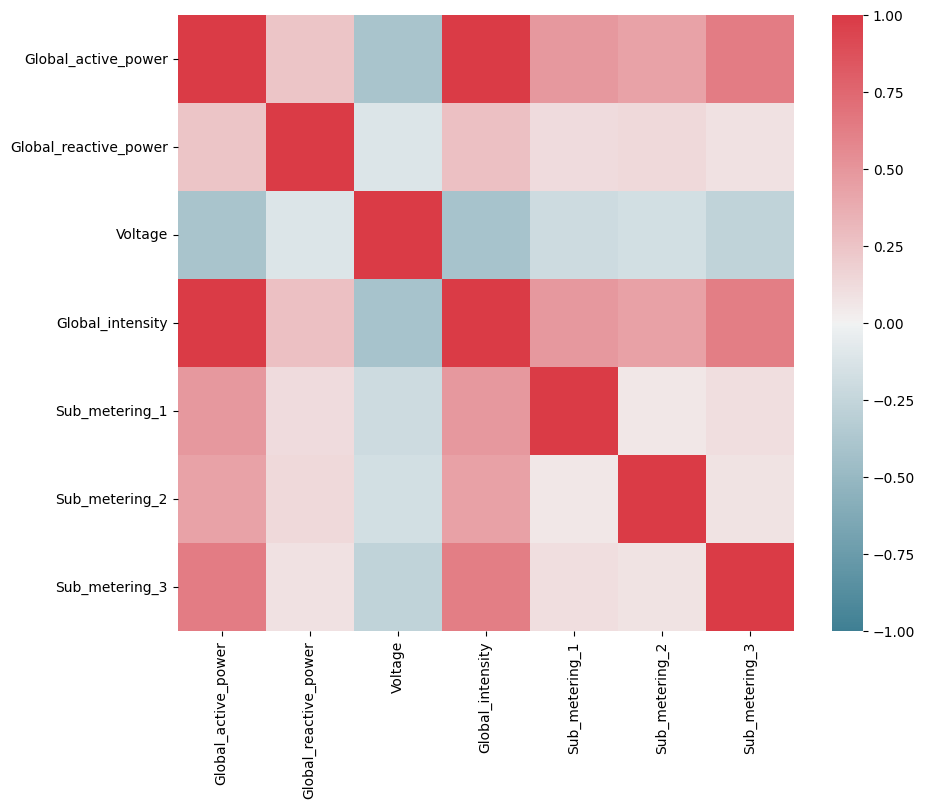

In [11]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = dataset.corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

### • Data Normalization

### • We want to normalize between 0 and 1 values

In [12]:
values = dataset.values
scaler = MinMaxScaler(feature_range=(0, 1))
data_set_scaled = scaler.fit_transform(dataset.values)

# Convert the scaled array back into a DataFrame
data_set_scaled_df = pd.DataFrame(data_set_scaled, columns=dataset.columns)

# Optionally, you can add the index back if needed:
data_set_scaled_df.index = dataset.index

# Display the first few rows of the scaled data
print(data_set_scaled_df.head())
print(data_set_scaled_df.shape)

                     Global_active_power  Global_reactive_power   Voltage  \
dt                                                                          
2006-12-16 17:24:00             0.374796               0.300719  0.376090   
2006-12-16 17:25:00             0.478363               0.313669  0.336995   
2006-12-16 17:26:00             0.479631               0.358273  0.326010   
2006-12-16 17:27:00             0.480898               0.361151  0.340549   
2006-12-16 17:28:00             0.325005               0.379856  0.403231   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00          0.377593             0.0          0.0125   
2006-12-16 17:25:00          0.473029             0.0          0.0125   
2006-12-16 17:26:00          0.473029             0.0          0.0250   
2006-12-16 17:27:00          0.473029             0.0          0.0125   
2006-12-16 17:28:00   

### Let's plot the AutoCorrelation of the data to see how long should our sequences be

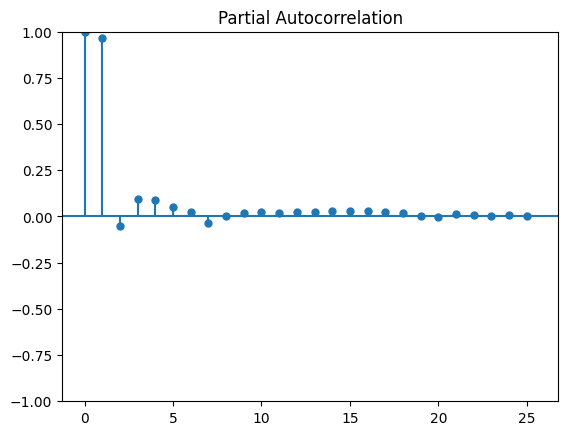

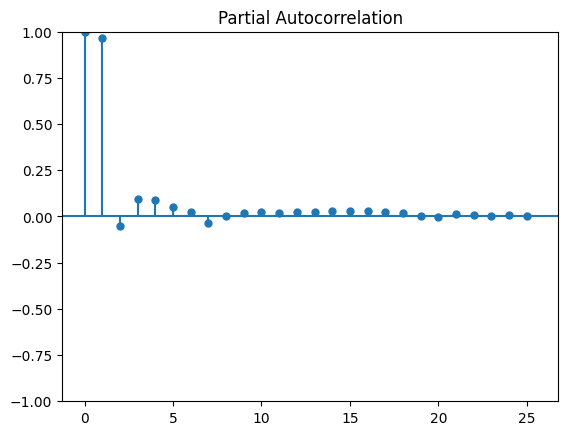

In [13]:
#plot_acf(data_set_scaled_df.Global_active_power, lags=25)
plot_pacf(data_set_scaled_df.Global_active_power, lags=25)

### Create dataset for timeseries sequence format

In [14]:
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        # Get a slice of 'time_steps' rows
        seq = data.iloc[i:i + time_steps].values
        sequences.append(seq)
    return np.array(sequences)

In [15]:
X = data_set_scaled_df.drop('Global_active_power', axis=1)
y = data_set_scaled_df['Global_active_power']

print(X.shape)
print(y.shape)

# Create sequences of 10 time steps each
dataset_time_series = create_sequences(X, past_time_steps)

# Remove the first 10 rows only form Y
y = y.iloc[past_time_steps:]

print(X.shape)
print(y.shape)

(2075259, 6)
(2075259,)
(2075259, 6)
(2075255,)


### • Now lets split the dataset into training and test

### • We will use 80% for training, 10% for validation and 10% for test

### • Important: Notice that the test partition is composed of the 10% newest data

In [16]:
# Step 1: Split into train (80%) and remaining (20%)
X_train, X_remaining, y_train, y_remaining = train_test_split(dataset_time_series, y, train_size=0.9, shuffle=False)


# Step 2: Split remaining data into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, shuffle=False)

print("Dimensions of training data: ", X_train.shape)
print("Dimensions of training labels: ", y_train.shape)

print("Dimensions of validation data: ", X_val.shape)
print("Dimensions of validation labels: ", y_val.shape)

print("Dimensions of test data: ", X_test.shape)
print("Dimensions of test data: ", y_test.shape)


Dimensions of training data:  (1867729, 4, 6)
Dimensions of training labels:  (1867729,)
Dimensions of validation data:  (103763, 4, 6)
Dimensions of validation labels:  (103763,)
Dimensions of test data:  (103763, 4, 6)
Dimensions of test data:  (103763,)


### Architecture #1 - Temporal CNN

###  The Temporal CNN is designed to capture patterns in sequential data over time by using 1D convolutional layers.

In [17]:
def create_temporal_CNN(input_shape=reshapable_dimension):
    # Define the Temporal CNN model
    model = Sequential()

    # First convolutional layer
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=input_shape))

    # Add max pooling to down-sample the time dimension
    model.add(MaxPooling1D(pool_size=1))

    # Second convolutional layer
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

    # Add another max pooling layer
    model.add(MaxPooling1D(pool_size=1))

    # Flatten the output before the dense layers
    model.add(Flatten())

    # Fully connected dense layer
    model.add(Dense(128, activation='relu'))

    # Optional dropout for regularization
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='relu'))
    
    return model

In [18]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_TCNNN_loaded_from_disk = False

if os.path.isfile(checkpoints_TCN + '/'  + checkpoint_filename_load):
    print("Loading saved TCNN model!!!")
    temporal_CNN_model = tf.keras.models.load_model(checkpoints_TCN + '/'  + checkpoint_filename_load)
    was_TCNNN_loaded_from_disk = True
else:
    print("Creating TCNN model!!!")
    temporal_CNN_model = create_temporal_CNN(input_shape = reshapable_dimension)
    
temporal_CNN_model.summary()

Creating TCNN model!!!
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 32)             416       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 32)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             4160      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (Non

### Architecture #2 - SCINet

### SCINet (S-Sequence Convolutional Neural Network) is a deep learning architecture specifically designed for time series forecasting. It focuses on splitting the input sequence recursively into sub-sequences and processing them separately, enabling the model to learn different temporal patterns at multiple scales.

In [19]:
def split_sequence(data_sequence):
    """Splits the sequence into odd and even parts."""
    odd_seq = data_sequence[:, 1::2, :]
    even_seq = data_sequence[:, 0::2, :]
    return odd_seq, even_seq

def merge_sequence(odd_sequence, even_sequence):
    """Merges odd and even sequences back."""
    """Merges odd and even sequences back together by interleaving odd and even sequences."""
    interleaved = tf.reshape(tf.concat([even_sequence, odd_sequence], axis=-1), 
                             (tf.shape(even_sequence)[0], -1, tf.shape(even_sequence)[-1]))
    return interleaved

def scinet_block(inputs, filters, kernel_size=3):
    """Defines a single SCINet block with split, merge, and residual connections."""
    # Split input into odd and even sequences
    odd_seq, even_seq = split_sequence(inputs)
    
    # Apply separate convolutions to odd and even sequences
    conv1d_odd = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation='relu')
    conv1d_even = tf.keras.layers.Conv1D(filters, kernel_size, padding='same', activation='relu')
    
    odd_processed = conv1d_odd(odd_seq)
    even_processed = conv1d_even(even_seq)
    
    # Merge processed odd and even sequences back together
    combined_seq = merge_sequence(odd_processed, even_processed)
    
    # Apply residual connection
    conv1d_residual = tf.keras.layers.Conv1D(filters, kernel_size, padding='same')
    residual = conv1d_residual(inputs)
    
    return combined_seq + residual

def create_SCINet_model(num_blocks, filters, output_units=1, kernel_size=3, input_shape=(10, 6)):
    #model = Sequential()
     
    """Builds the full SCINet model using the SCINet blocks."""
    inputs = tf.keras.layers.Input(shape=input_shape[0:])
    x = inputs
    
    # Apply each SCINet block sequentially
    for _ in range(num_blocks):
        x = scinet_block(x, filters, kernel_size)
    
    output_conv = tf.keras.layers.Conv1D(output_units, 1)(x)

    # Option 1: Use GlobalAveragePooling1D
    outputs = tf.keras.layers.GlobalAveragePooling1D()(output_conv)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [20]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_SCINet_loaded_from_disk = False

if os.path.isfile(checkpoints_SCINet + '/'  + checkpoint_filename_load):
    print("Loading saved SCINet model!!!")
    SCINet_model = tf.keras.models.load_model(checkpoints_SCINet+ '/'  + checkpoint_filename_load)
    was_SCINet_loaded_from_disk = True
else:
    print("Creating SCINet model!!!")
    SCINet_model = create_SCINet_model(num_blocks = 3, filters = 128, output_units=1, kernel_size=3, input_shape = reshapable_dimension)
    SCINet_model.build(input_shape = reshapable_dimension)
    
SCINet_model.summary()

Creating SCINet model!!!
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 6)]       0           []                               
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 2, 6)        0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 conv1d_3 (Conv1D)              (None, 2, 128)       2432        ['tf.__operators__.getitem_1[0][0
                                                                 ]']                              
                                                                     

### Architecture #3 SegRNN (Segmentation Recurrent Neural Network)

In [21]:
def create_SegRNN_model(rnn_units=100, rnn_type='gru', input_shape = reshapable_dimension):
    model = Sequential()
     
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))

    # Bidirectional RNN for long-term dependencies (can be GRU or LSTM)
    if rnn_type == 'gru':
        model.add(GRU(rnn_units,activation='relu', return_sequences=False))
    else:
        model.add(LSTM(rnn_units,activation='relu', return_sequences=False))
    
    # Fully connected layer for output
    model.add(Dense(1))
    
    return model

In [22]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_SegRNN_LSTM_loaded_from_disk = False

if os.path.isfile(checkpoints_SegRNN_LSTM + '/'  + checkpoint_filename_load):
    print("Loading saved SegRNN-LSTM model!!!")
    SegRNN_LSTM_model = tf.keras.models.load_model(checkpoints_SegRNN_LSTM + '/'  + checkpoint_filename_load)
    was_SegRNN_LSTM_loaded_from_disk = True
else:
    print("Creating SegRNN-LSTM model!!!")
    SegRNN_LSTM_model = create_SegRNN_model(rnn_units=100, rnn_type='lstm',input_shape = reshapable_dimension)
    
SegRNN_LSTM_model.summary()

Creating SegRNN-LSTM model!!!
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 2, 32)             608       
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 53,909
Trainable params: 53,909
Non-trainable params: 0
_________________________________________________________________


In [23]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_SegRNN_GRU_loaded_from_disk = False

if os.path.isfile(checkpoints_SegRNN_GRU + '/'  + checkpoint_filename_load):
    print("Loading saved SegRNN-GRU model!!!")
    SegRNN_GRU_model = tf.keras.models.load_model(checkpoints_SegRNN_GRU + '/'  + checkpoint_filename_load)
    was_SegRNN_GRU_loaded_from_disk = True
else:
    print("Creating SegRNN-GRU model!!!")
    SegRNN_GRU_model = create_SegRNN_model(rnn_units=100, rnn_type='gru',input_shape = reshapable_dimension)
    
SegRNN_GRU_model.summary()

Creating SegRNN-GRU model!!!
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 2, 32)             608       
                                                                 
 gru (GRU)                   (None, 100)               40200     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,909
Trainable params: 40,909
Non-trainable params: 0
_________________________________________________________________


### Architecture #4 Transformer-Based Architecture

In [24]:
def positional_encoding(position, d_model):
    """Generates the positional encoding matrix."""
    angle_rads = get_angles(tf.range(position, dtype=tf.float32)[:, tf.newaxis],
                            tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
                            d_model)

    # Apply sin to even indices and cos to odd indices
    sines = tf.math.sin(angle_rads[:, 0::2])
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # Concatenate sines and cosines along the last axis
    pos_encoding = tf.concat([sines, cosines], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)[tf.newaxis, ...]

def get_angles(pos, i, d_model):
    """Helper function to calculate angles for positional encoding."""
    angle_rates = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return pos * angle_rates

def transformer_encoder(inputs, num_heads, d_model, ff_dim, dropout_rate=0.1, num_layers=2):
    """Defines the Transformer encoder with specified number of layers and configurations."""
    pos_encoding = positional_encoding(1000, d_model)  # Assume max_seq_len=1000 for simplicity
    seq_len = tf.shape(inputs)[1]
    inputs = tf.keras.layers.Dense(d_model)(inputs)  # Input projection
    inputs += pos_encoding[:, :seq_len, :]  # Add positional encoding

    for _ in range(num_layers):
        # Multi-head self-attention
        attn_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)(inputs, inputs)
        attn_output = tf.keras.layers.Dropout(dropout_rate)(attn_output)
        inputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)  # Residual connection

        # Feed-forward network
        ff_output = tf.keras.Sequential([
            tf.keras.layers.Dense(ff_dim, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])(inputs)
        ff_output = tf.keras.layers.Dropout(dropout_rate)(ff_output)
        inputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + ff_output)  # Residual connection

    return inputs

def create_transformer_model(input_shape, num_heads, d_model, num_layers, ff_dim, output_steps, input_dim, dropout_rate=0.3):
    """Builds the TimeSeriesTransformer model using functional layers."""
    inputs = tf.keras.layers.Input(shape=input_shape[0:])
    
    # Transformer encoder
    encoder_output = transformer_encoder(inputs, num_heads, d_model, ff_dim, dropout_rate, num_layers)
    
    # Output projection to predict future steps
    output = tf.keras.layers.Dense(1)(encoder_output[:, -1, :])
    
    return tf.keras.Model(inputs=inputs, outputs=output)

In [25]:
#First we try to load the saved model, if exists we loaded otherwise we create a new one
was_transformer_model_loaded_from_disk = False

if os.path.isfile(checkpoints_transfomer + '/'  + checkpoint_filename_load):
    print("Loading saved Transformer model!!!")
    transformer_model = tf.keras.models.load_model(checkpoints_transfomer+ '/'  + checkpoint_filename_load)
    was_transformer_model_loaded_from_disk = True
else:
    print("Creating Transformer model!!!")
    transformer_model = create_transformer_model(input_shape = reshapable_dimension, num_heads=4, d_model=32, num_layers=2, ff_dim=128, output_steps=1, input_dim=6, dropout_rate=0.3 )
    transformer_model.build(input_shape = reshapable_dimension)
    
transformer_model.summary()

Creating Transformer model!!!
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 4, 6)]       0           []                               
                                                                                                  
 tf.compat.v1.shape_6 (TFOpLamb  (3,)                0           ['input_2[0][0]']                
 da)                                                                                              
                                                                                                  
 tf.__operators__.getitem_12 (S  ()                  0           ['tf.compat.v1.shape_6[0][0]']   
 licingOpLambda)                                                                                  
                                                              

# *********************** Training phase *************************

### We use this common function to train all the architectures of our project, it also creates the checkpoints that we will save for each architecture

In [26]:
# Training the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=50, checkpoint_dir=''):
    # Compile the model
    model.compile(optimizer='adam', loss='mse', metrics=['Precision', 'mae'])

    # Create checkpoints folder
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, checkpoint_filename),
        save_weights_only=False,  # Save the entire model, not just weights
        save_best_only=False,     # Save the model after every epoch, not just the best one
        monitor='loss',
        mode='min'
    )
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), callbacks=[checkpoint_cb])
    return history

In [27]:
def visualize_metrics(history, under_lim = -1, upper_lim = 1):
    pd.DataFrame(history.history).plot(figsize=(10, 7))
    plt.grid(True)
    plt.gca().set_ylim(under_lim, upper_lim)
    plt.xlabel("epochs")
    plt.show()

In [ ]:
if was_TCNNN_loaded_from_disk is False:
    history = train_model(temporal_CNN_model, X_train, y_train, X_val, y_val, batch_size=64, epochs=train_epochs_amount, checkpoint_dir=checkpoints_TCN)
    visualize_metrics(history)

Epoch 1/20
29184/29184 [==============================] - 447s 15ms/step - loss: 7.7294e-04 - precision: 1.0000 - mae: 0.0155 - val_loss: 2.9858e-04 - val_precision: 1.0000 - val_mae: 0.0114
Epoch 2/20
29184/29184 [==============================] - 448s 15ms/step - loss: 7.1527e-04 - precision: 1.0000 - mae: 0.0148 - val_loss: 2.3919e-04 - val_precision: 0.0000e+00 - val_mae: 0.0074
Epoch 3/20
29184/29184 [==============================] - 379s 13ms/step - loss: 6.9657e-04 - precision: 1.0000 - mae: 0.0145 - val_loss: 2.4188e-04 - val_precision: 0.0000e+00 - val_mae: 0.0077
Epoch 4/20
29184/29184 [==============================] - 454s 16ms/step - loss: 6.7851e-04 - precision: 1.0000 - mae: 0.0143 - val_loss: 2.5885e-04 - val_precision: 1.0000 - val_mae: 0.0089
Epoch 7/20
29184/29184 [==============================] - 469s 16ms/step - loss: 6.7898e-04 - precision: 1.0000 - mae: 0.0143 - val_loss: 2.4319e-04 - val_precision: 1.0000 - val_mae: 0.0082
Epoch 8/20
29184/29184 [=============

In [ ]:
if was_SegRNN_LSTM_loaded_from_disk is False:
    history = train_model(SegRNN_LSTM_model, X_train, y_train, X_val, y_val, batch_size=64, epochs=train_epochs_amount, checkpoint_dir=checkpoints_SegRNN_LSTM)
    visualize_metrics(history)

29184/29184 [==============================] - 129s 4ms/step - loss: 5.5557e-04 - precision: 1.0000 - mae: 0.0104 - val_loss: 2.3532e-04 - val_precision: 1.0000 - val_mae: 0.0064
Epoch 2/20
28458/29184 [============================>.] - ETA: 3s - loss: 5.0108e-04 - precision: 1.0000 - mae: 0.0095

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



29184/29184 [==============================] - 128s 4ms/step - loss: 4.7685e-04 - precision: 1.0000 - mae: 0.0090 - val_loss: 2.1646e-04 - val_precision: 1.0000 - val_mae: 0.0059
Epoch 5/20
29184/29184 [==============================] - 127s 4ms/step - loss: 4.7017e-04 - precision: 1.0000 - mae: 0.0089 - val_loss: 2.1862e-04 - val_precision: 1.0000 - val_mae: 0.0060
Epoch 6/20
29184/29184 [==============================] - 126s 4ms/step - loss: 4.6529e-04 - precision: 1.0000 - mae: 0.0088 - val_loss: 2.3266e-04 - val_precision: 1.0000 - val_mae: 0.0083
Epoch 7/20
29184/29184 [==============================] - 132s 5ms/step - loss: 4.6118e-04 - precision: 1.0000 - mae: 0.0087 - val_loss: 2.2318e-04 - val_precision: 1.0000 - val_mae: 0.0070
Epoch 8/20
29184/29184 [==============================] - 126s 4ms/step - loss: 4.5819e-04 - precision: 1.0000 - mae: 0.0087 - val_loss: 2.0996e-04 - val_precision: 1.0000 - val_mae: 0.0056
Epoch 9/20
29184/29184 [==============================] - 128

In [ ]:
if was_SegRNN_GRU_loaded_from_disk is False:
    history = train_model(SegRNN_GRU_model, X_train, y_train, X_val, y_val, batch_size=64, epochs=train_epochs_amount, checkpoint_dir=checkpoints_SegRNN_GRU)
    visualize_metrics(history)

29184/29184 [==============================] - 138s 5ms/step - loss: 5.4656e-04 - precision: 1.0000 - mae: 0.0104 - val_loss: 2.3397e-04 - val_precision: 1.0000 - val_mae: 0.0069
Epoch 2/20
29184/29184 [==============================] - 133s 5ms/step - loss: 4.9791e-04 - precision: 1.0000 - mae: 0.0095 - val_loss: 2.2954e-04 - val_precision: 1.0000 - val_mae: 0.0064
Epoch 3/20
29184/29184 [==============================] - 133s 5ms/step - loss: 4.8526e-04 - precision: 1.0000 - mae: 0.0092 - val_loss: 2.2267e-04 - val_precision: 1.0000 - val_mae: 0.0070
Epoch 4/20
29184/29184 [==============================] - 132s 5ms/step - loss: 4.7830e-04 - precision: 1.0000 - mae: 0.0091 - val_loss: 2.1680e-04 - val_precision: 1.0000 - val_mae: 0.0058
Epoch 5/20
29184/29184 [==============================] - 133s 5ms/step - loss: 4.7314e-04 - precision: 1.0000 - mae: 0.0090 - val_loss: 2.1544e-04 - val_precision: 1.0000 - val_mae: 0.0060
Epoch 6/20
29184/29184 [==============================] - 139

In [ ]:
if was_SCINet_loaded_from_disk is False:
    history = train_model(SCINet_model, X_train, y_train, X_val, y_val, batch_size=256, epochs=train_epochs_amount, checkpoint_dir=checkpoints_SCINet)
    visualize_metrics(history)

7296/7296 [==============================] - 464s 63ms/step - loss: 6.7642e-04 - precision: 1.0000 - mae: 0.0113 - val_loss: 2.3002e-04 - val_precision: 1.0000 - val_mae: 0.0064
Epoch 2/20
7296/7296 [==============================] - 485s 66ms/step - loss: 4.4751e-04 - precision: 1.0000 - mae: 0.0086 - val_loss: 2.0497e-04 - val_precision: 1.0000 - val_mae: 0.0061
Epoch 10/20
7296/7296 [==============================] - 477s 65ms/step - loss: 4.4492e-04 - precision: 1.0000 - mae: 0.0086 - val_loss: 2.0760e-04 - val_precision: 1.0000 - val_mae: 0.0071
Epoch 11/20
7296/7296 [==============================] - 452s 62ms/step - loss: 4.4312e-04 - precision: 1.0000 - mae: 0.0086 - val_loss: 2.1140e-04 - val_precision: 1.0000 - val_mae: 0.0061
Epoch 12/20
7296/7296 [==============================] - 462s 63ms/step - loss: 4.4069e-04 - precision: 1.0000 - mae: 0.0086 - val_loss: 2.0241e-04 - val_precision: 1.0000 - val_mae: 0.0055
Epoch 13/20
3744/7296 [==============>...............] - ETA: 4

29184/29184 [==============================] - 452s 15ms/step - loss: 0.0017 - precision: 1.0000 - mae: 0.0195 - val_loss: 2.5373e-04 - val_precision: 1.0000 - val_mae: 0.0062
Epoch 2/20
29184/29184 [==============================] - 441s 15ms/step - loss: 5.6644e-04 - precision: 1.0000 - mae: 0.0108 - val_loss: 2.8368e-04 - val_precision: 1.0000 - val_mae: 0.0093
Epoch 3/20
29184/29184 [==============================] - 428s 15ms/step - loss: 5.4661e-04 - precision: 1.0000 - mae: 0.0101 - val_loss: 2.5692e-04 - val_precision: 1.0000 - val_mae: 0.0078
Epoch 4/20
29184/29184 [==============================] - 431s 15ms/step - loss: 5.3611e-04 - precision: 1.0000 - mae: 0.0099 - val_loss: 2.4958e-04 - val_precision: 1.0000 - val_mae: 0.0066
Epoch 5/20
29184/29184 [==============================] - 430s 15ms/step - loss: 5.3143e-04 - precision: 1.0000 - mae: 0.0097 - val_loss: 2.6219e-04 - val_precision: 1.0000 - val_mae: 0.0077
Epoch 6/20
29184/29184 [==============================] - 43

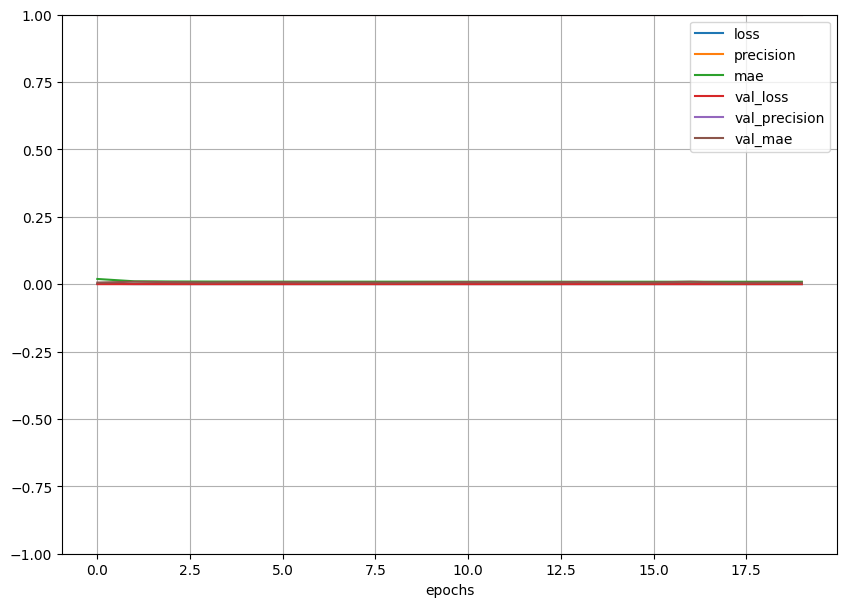

In [32]:
if was_transformer_model_loaded_from_disk is False:
    history = train_model(transformer_model, X_train, y_train, X_val, y_val, batch_size=64, epochs=train_epochs_amount, checkpoint_dir=checkpoints_transfomer)
    visualize_metrics(history)

### • Predict

In [33]:
# Evaluación del modelo
predicted_TCNN = temporal_CNN_model.predict(X_test)

predicted_SegRNN_LSTM = SegRNN_LSTM_model.predict(X_test)

predicted_SegRNN_GRU = SegRNN_GRU_model.predict(X_test)

predicted_SCINet = SCINet_model.predict(X_test)

predicted_transformer = transformer_model.predict(X_test)


3243/3243 [==============================] - 14s 4ms/step


### Plot comparissions real vs predicted

In [34]:
def plotComparisonPredicted(test, predicted, amount):
    aa=[x for x in range(amount)]
    plt.plot(aa, test[:amount], marker='.', label="actual")
    plt.plot(aa, predicted[:amount], '+', label="prediction")
    plt.ylabel('Global_active_power', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

In [35]:
def plotComparisonPredictedRandom(test, predicted, amount):
    rand_list=[]
    test_observation = []
    predicted_observation = []
    for i in range(amount):
        randomObservation = random.randint(amount, len(test))
        test_observation.append(test.iloc[randomObservation])
        predicted_observation.append(predicted[randomObservation])
        rand_list.append(randomObservation)
    aa=[x for x in range(amount)]
    plt.plot(aa, test_observation[:amount], marker='.', label="actual")
    plt.plot(aa, predicted_observation[:amount], '+', label="prediction")
    plt.ylabel('Global_active_power', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

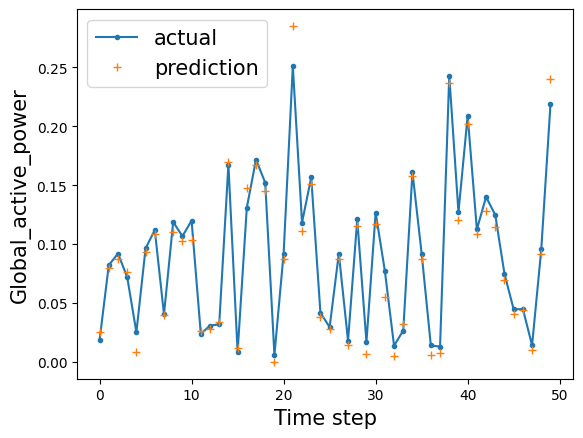

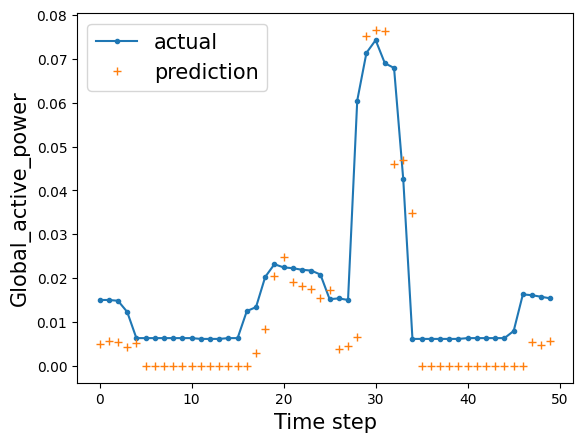

In [36]:
plotComparisonPredictedRandom(y_test, predicted_TCNN, 50)
plotComparisonPredicted(y_test, predicted_TCNN, 50)

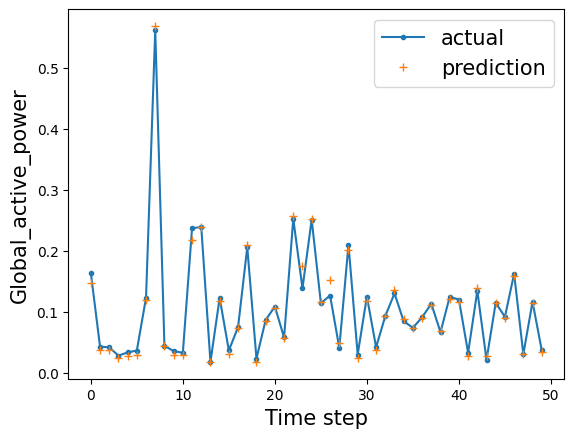

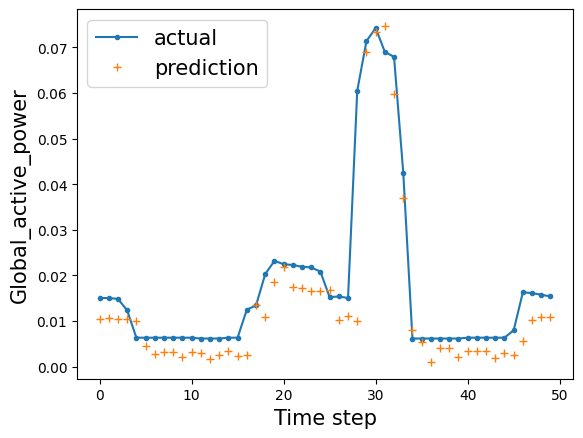

In [37]:
plotComparisonPredictedRandom(y_test, predicted_SegRNN_LSTM, 50)
plotComparisonPredicted(y_test, predicted_SegRNN_LSTM, 50)

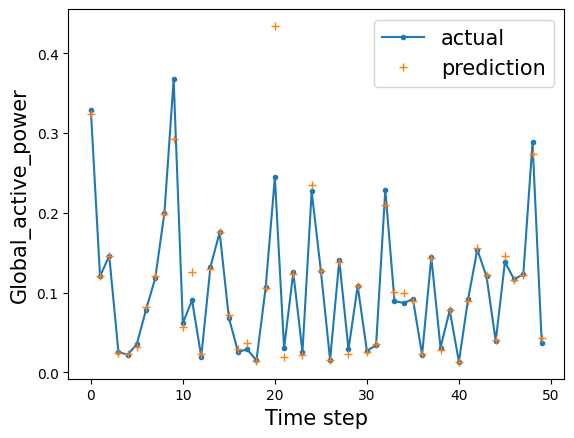

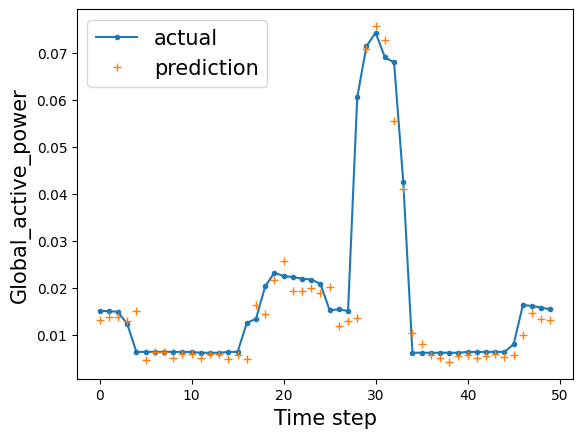

In [38]:
plotComparisonPredictedRandom(y_test, predicted_SegRNN_GRU, 50)
plotComparisonPredicted(y_test, predicted_SegRNN_GRU, 50)

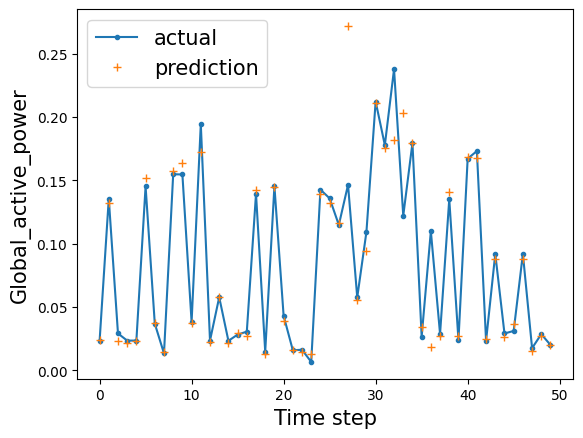

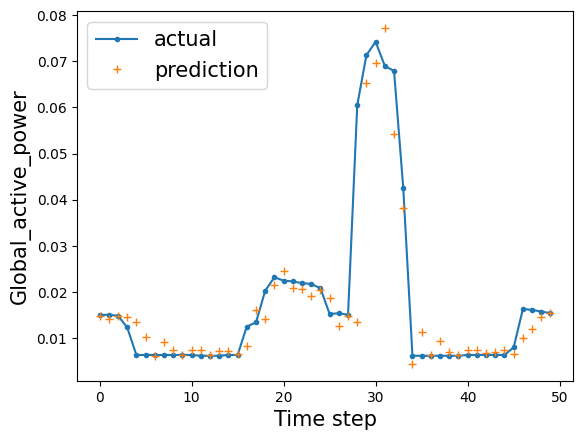

In [39]:
plotComparisonPredictedRandom(y_test, predicted_SCINet, 50)
plotComparisonPredicted(y_test, predicted_SCINet, 50)

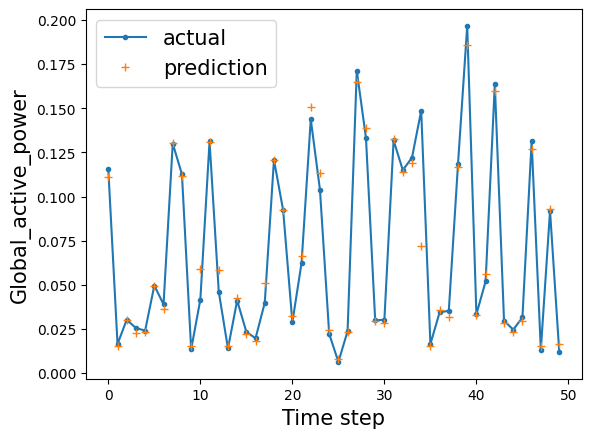

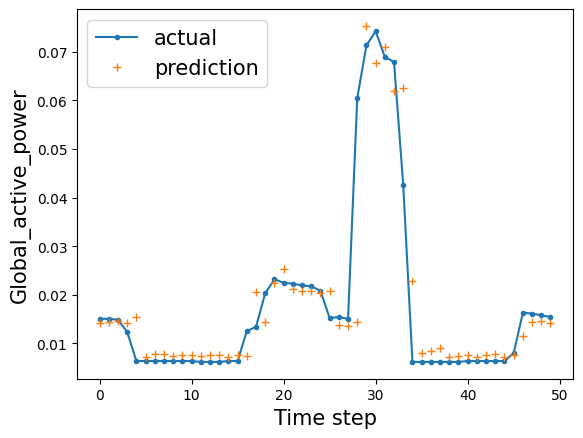

In [40]:
plotComparisonPredictedRandom(y_test, predicted_transformer, 50)
plotComparisonPredicted(y_test, predicted_transformer, 50)